Author: Diego Guillen-Rosaperez <br />
Contact via LinkedIn: https://de.linkedin.com/in/diego-guillen

# Import packages and libraries

In [1]:
import os, fnmatch
import pandas as pd
import numpy as np
 
%matplotlib inline
#%matplotlib notebook
import matplotlib as mpl
from matplotlib import pylab as plt

Jump to [Checkpoint after preprocessing](#anchor_checkpoint)

# Load and visualize the raw data

This data was collected in the press 1 channel 0, which sensor measures the pressure after the oil pump. The sampling rate was 1 kHz. It belongs to multiple work days, including a day when the press had: <br/>
* a healthy pressure accumulator
* a breakdown day
* a day when the accumulator was degradating
* an arbitrary day

In [2]:
pattern = ".*"

# Healthy day
data_dir1 = '/mnt/Shared/Thesis/2020-06-24/device_1_channel_0'
merged_data = pd.DataFrame()                  # Setup empty dataframe 
listOfFiles = os.listdir(data_dir1)           # List all directories
for entry in listOfFiles:                     # Iterate through all data files
    if not fnmatch.fnmatch(entry, '*.ini'):   # Ignore sum check from parquet compression
        df = pd.read_parquet(data_dir1 + '/' + entry, engine='fastparquet')
        merged_data = pd.concat([merged_data, df], axis=0, join='outer', ignore_index=True, sort=False)
df = merged_data
del merged_data

# Intermediate/Deteriorating day
data_dir2 = '/mnt/Shared/Thesis/2020-06-03/device_1_channel_0'
merged_data = pd.DataFrame()
listOfFiles = os.listdir(data_dir2)
for entry in listOfFiles:
    if not fnmatch.fnmatch(entry, '*.ini'):
        df2 = pd.read_parquet(data_dir2 + '/' + entry)
        merged_data = pd.concat([merged_data, df2], axis=0, join='outer', ignore_index=True, sort=False)
df2 = merged_data
del merged_data

# Breakdown day
data_dir3 = '/mnt/Shared/Thesis/2020-06-20/device_1_channel_0'
merged_data = pd.DataFrame()
listOfFiles = os.listdir(data_dir3)
for entry in listOfFiles:
    if not fnmatch.fnmatch(entry, '*.ini'):
        df3 = pd.read_parquet(data_dir3 + '/' + entry)
        merged_data = pd.concat([merged_data, df3], axis=0, join='outer', ignore_index=True, sort=False)
df3 = merged_data
del merged_data

# Random day
data_dir4 = '/mnt/Shared/Thesis/2020-02-24/device_1_channel_0'
merged_data = pd.DataFrame()
listOfFiles = os.listdir(data_dir4)
for entry in listOfFiles:
    if not fnmatch.fnmatch(entry, '*.ini'):
        df4 = pd.read_parquet(data_dir4 + '/' + entry)
        merged_data = pd.concat([merged_data, df4], axis=0, join='outer', ignore_index=True, sort=False)
df4 = merged_data
del merged_data

# Combine all days
df = pd.concat([df,df2,df3,df4], axis=0, join='outer', ignore_index=True, sort=False)

print("Total length: " + str(len(df)))

Total length: 213304990


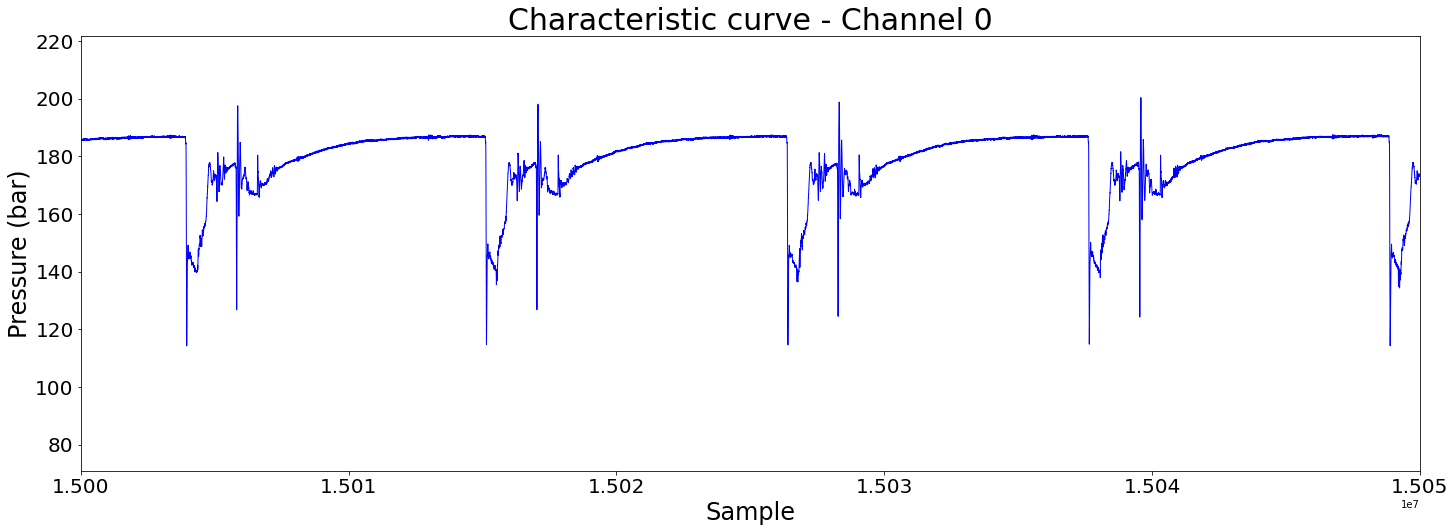

In [5]:
%matplotlib inline
fig = plt.figure(figsize=(24, 8))

ax = fig.add_subplot(1, 1, 1)
plt.title("Characteristic curve - Channel 0", fontsize=30)
plt.plot(df['value'],color="b",linewidth=1)
ax.set_xlim(15000000,15050000)
plt.xlabel('Sample', fontsize=24)
plt.ylabel('Pressure (bar)', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

Here, we see how a typical work cycle looks like.

# Data pre-processing

### Look for nan values and replace them

In [6]:
if df.isnull().sum().sum() > 0:
    df = df.fillna(0)
    print("Nans replaced")
else:
    print("Nothing to replace")

Nothing to replace


### Identify peaks and work cycles

The pressure is measured continously during the whole day; either if the press is working, is waiting, etc. Therefore, we want to extract only the data corresponding to work cycles. To do so, we identify a distinctive mark, a peak value in this case, and we trim to its right and left. We tune manually the scipy method to fit for most peaks. <br/>
Hint: There are around 2500 work cycles per day. Thus around 10k work cycles are expected for 4 days.

In [8]:
from scipy.signal import find_peaks

d_coef = 1 # Downsampling coeficient used. 1=no downsampling was used

# Find peaks: peaks is an array, where the locaton of the peaks
# distance: samples between neighbouring peaks
# prominence: [min,max] prominence
peaks, _ = find_peaks(df['value'], distance=11000/d_coef, prominence=[20,150], width=[100,11000]) # Hyperparameters

print("Identified peaks in Ch0: ",len(peaks))

Identified peaks in Ch0:  9972


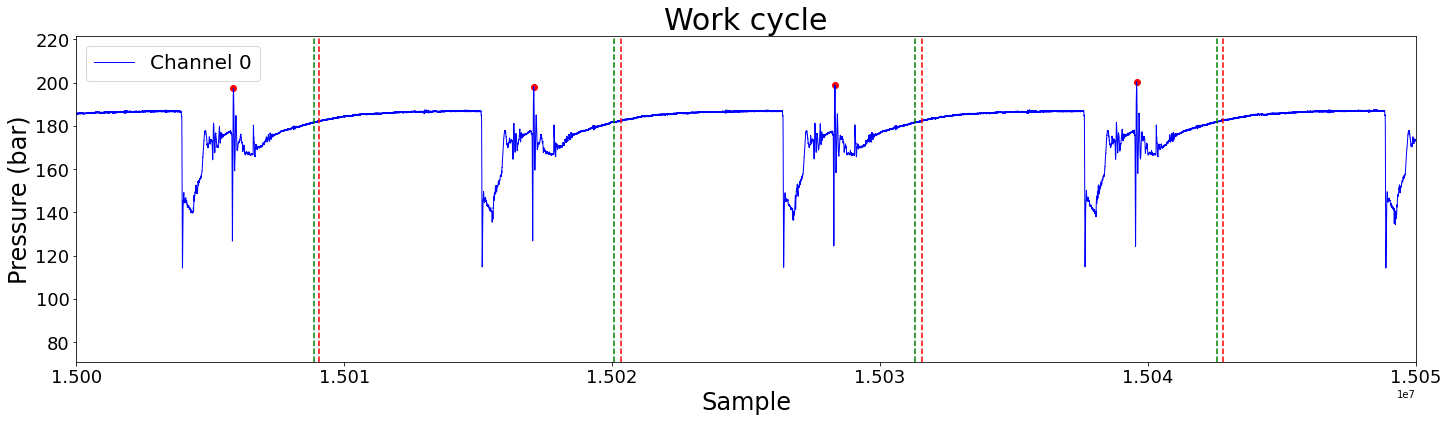

In [10]:
fig = plt.figure(figsize=(24, 6))
ax = fig.add_subplot(1, 1, 1)
plt.title("Work cycle", fontsize=30)

plt.plot(peaks, df['value'][peaks],"o",color="red",linewidth=2)
plt.plot(df['value'],color='b',linewidth=1, label='Channel 0')

ax.set_xlim(15000000/d_coef,15050000/d_coef) # Work cycles
for i , p in enumerate(peaks):   
    if i > 0 and i <= peaks.shape[0] :
        ax.axvline(peaks[i]-8000/d_coef,color='r', linestyle='--') # work cycle begin
        ax.axvline(peaks[i]+3000/d_coef,color='g', linestyle='--') # work cycle end

plt.xlabel('Sample', fontsize=24)
plt.ylabel('Pressure (bar)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

ax.legend(loc=2, prop={'size': 20})
plt.show()

### Inspect visually that all work cycles are covered

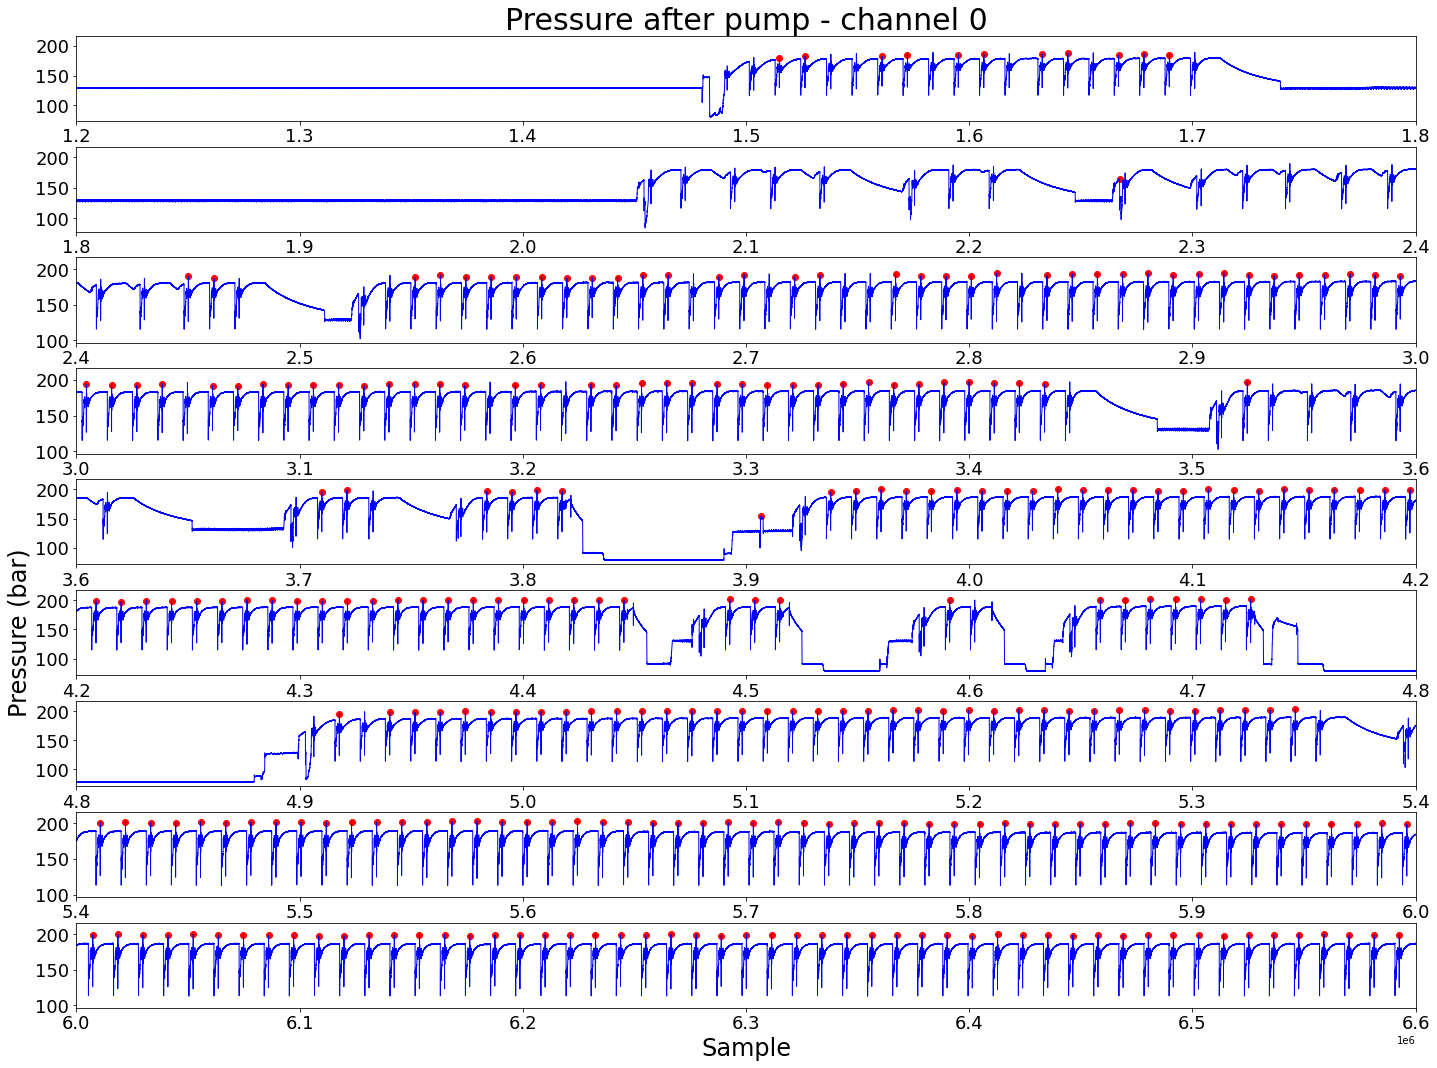

In [11]:
# Sampling frequency
freq = 1000 # 1kHz
# time in minutes to display per graph
time_to_plot = 10
# Resolution
time_resolution = 60*freq*time_to_plot

# Part 1: First 2 work hours
fig = plt.figure(figsize=(24, 24))

for i in range(3,12): # Two hours plot
    ax = fig.add_subplot(12, 1, i)
    plt.plot(peaks, df['value'][peaks],"o",color="red",linewidth=2)
    plt.plot(df[time_resolution*(i-1):time_resolution*i],color='b',linewidth=1, label='Channel 0')
    ax.set_xlim(time_resolution*(i-1),time_resolution*i)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    if i == 3:
        plt.title("Pressure after pump - channel 0", fontsize=30)
    if i == 8:
        plt.ylabel('Pressure (bar)', fontsize=24)

plt.xlabel('Sample', fontsize=24)

plt.subplots_adjust(hspace=.3)
plt.show()

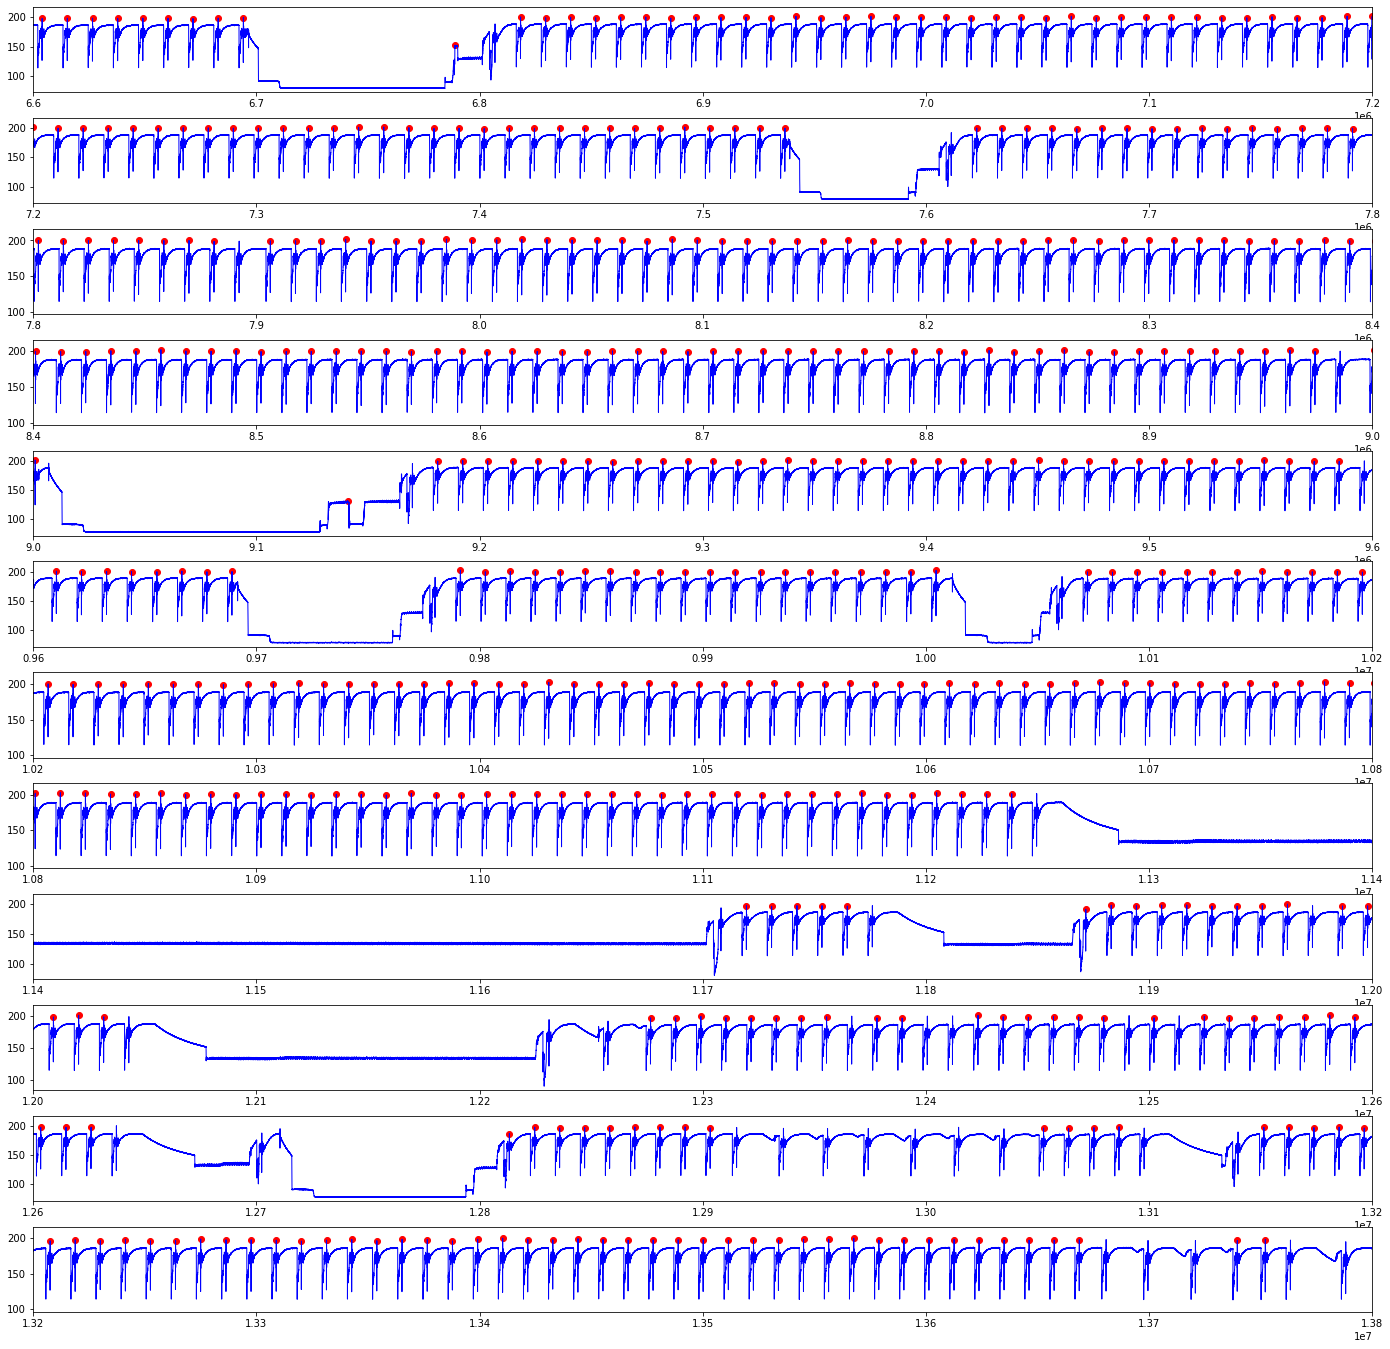

In [12]:
# another 2 work hours
time_resolution*100

fig = plt.figure(figsize=(24, 24))

for i in range(12,24): # Two hours plot
    ax = fig.add_subplot(12, 1, i-11)
    plt.plot(peaks, df['value'][peaks],"o",color="red",linewidth=2)
    plt.plot(df[time_resolution*(i-1):time_resolution*i],color='b',linewidth=1, label='Channel 0')
    ax.set_xlim(time_resolution*(i-1),time_resolution*i)
    
plt.subplots_adjust(hspace=.3)
plt.show()

We need to acknowledge that there are some small deviations on every work cycle. Therefore, although not every peak was identified, most of them were covered. This is fine since we are comparing data over multiple days because wear & tear shows across long periods of time.

### Divide dataframe into work cycles

Let's divide the dataframe into a new one, where each column represents a work cycle.

In [13]:
# Shuffe randomly the work cycles
np.random.shuffle(peaks)

In [15]:
from tqdm import tqdm

c_df = pd.DataFrame()
 
# This execution may required several minutes to run, and it is currently running in a single threat
for i in tqdm(range(0,len(peaks))):
    temp = df['value'][peaks[i]-8000:peaks[i]+3000]             # One cycle, before -8000
    temp.reset_index(drop=True, inplace=True)                   # Reset index
    
    c_df = pd.concat([c_df, temp], axis=1, ignore_index=True, sort=False) # Concatenate

# Delete temp variable
del temp

100%|██████████| 9972/9972 [12:39<00:00, 13.13it/s]


### Visualize work cycles

We inspect visually every work cycle by printing one on top of each other. We notice that there are some differences on their shape when comparing multiple days

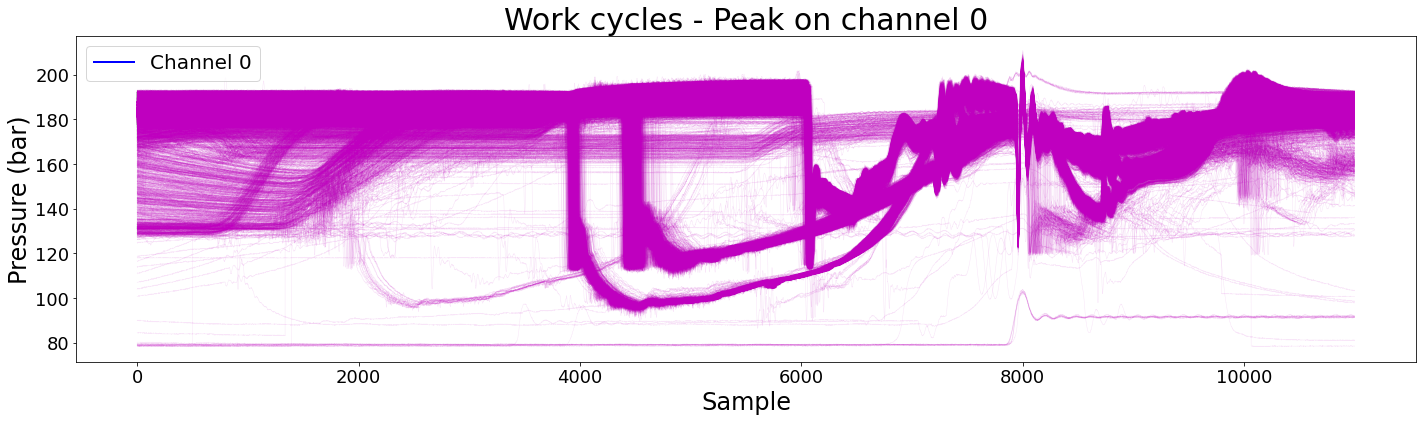

In [16]:
fig = plt.figure(figsize=(24, 6))
ax = fig.add_subplot(1, 1, 1)
plt.title("Work cycles - Peak on channel 0", fontsize=30)
for i in range(0,len(peaks)):
#for i in range(0,2):
    plt.plot(c_df[[i]],color='m',linewidth=0.5, alpha=0.1)

plt.xlabel('Sample', fontsize=24)
plt.ylabel('Pressure (bar)', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='b', lw=2)]
ax.legend(custom_lines, ['Channel 0'],loc=2, prop={'size': 20})
plt.show()

### Split data into a training and test dataset
When a data is flatten, it uses each row for dataset sample (in analogy one image is transform to a row)

In [17]:
dataset_train = c_df.iloc[:,0:(len(peaks)//5*4)] # first 80% dataFrame.iloc[<ROWS INDEX RANGE> , <COLUMNS INDEX RANGE>]
dataset_train = dataset_train.transpose()
dataset_test = c_df.iloc[:,(len(peaks)//5*4):len(peaks)] # last 20%
dataset_test = dataset_test.transpose()

print("dataset_train: ",dataset_train.shape)
print("dataset_test: ",dataset_test.shape)

dataset_train:  (7976, 11000)
dataset_test:  (1996, 11000)


### Normalize data

In [18]:
# Ch0
X_train = dataset_train/222
X_test = dataset_test/222

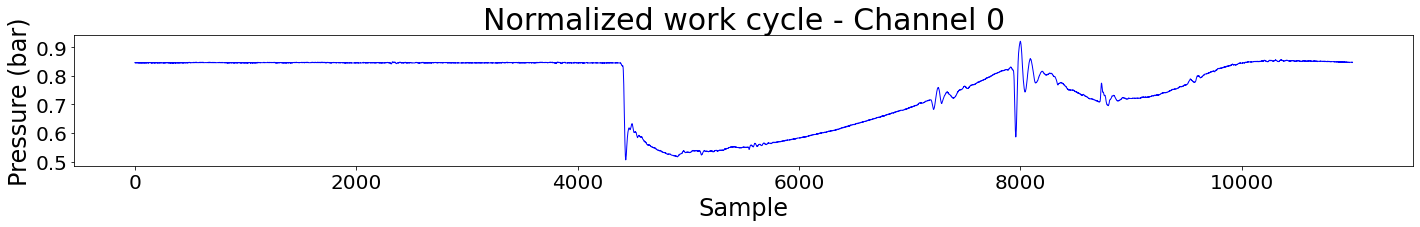

In [19]:
%matplotlib inline
fig = plt.figure(figsize=(24, 6))

ax = fig.add_subplot(2, 1, 1)
plt.title("Normalized work cycle - Channel 0", fontsize=30)
plt.plot(X_train.iloc[5,:],color="b",linewidth=1)
plt.xlabel('Sample', fontsize=24)
plt.ylabel('Pressure (bar)', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.subplots_adjust(hspace=.5)
plt.show()

In [20]:
## Save data
%store X_train
%store X_test

Stored 'X_train' (DataFrame)
Stored 'X_test' (DataFrame)


# Checkpoint
<a id='anchor_checkpoint'></a>
To all above was preprocessing. Below it's the DL model.

# Deep learning model

In [3]:
import os, fnmatch
import pandas as pd
import numpy as np
 
%matplotlib inline
#%matplotlib notebook
import matplotlib as mpl
from matplotlib import pylab as plt

## Load data
%store -r X_train
%store -r X_test

### Conv1DTranspose (Deconvolution)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D
from tensorflow.keras import activations, initializers, constraints
from tensorflow import TensorShape
from tensorflow.keras.layers import InputSpec
from tensorflow.python.ops import array_ops, nn_ops
from tensorflow.python.keras.utils import conv_utils

class Conv1DTranspose(Conv1D):
  def __init__(self,
               filters,
               kernel_size,
               strides=1,
               padding='valid',
               output_padding=None,
               data_format=None,
               dilation_rate=1,
               activation=None,
               use_bias=True,
               kernel_initializer='glorot_uniform',
               bias_initializer='zeros',
               kernel_regularizer=None,
               bias_regularizer=None,
               activity_regularizer=None,
               kernel_constraint=None,
               bias_constraint=None,
               **kwargs):
    super(Conv1DTranspose, self).__init__(
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding=padding,
        data_format=data_format,
        dilation_rate=dilation_rate,
        activation=activations.get(activation),
        use_bias=use_bias,
        kernel_initializer=initializers.get(kernel_initializer),
        bias_initializer=initializers.get(bias_initializer),
        kernel_regularizer=regularizers.get(kernel_regularizer),
        bias_regularizer=regularizers.get(bias_regularizer),
        activity_regularizer=regularizers.get(activity_regularizer),
        kernel_constraint=constraints.get(kernel_constraint),
        bias_constraint=constraints.get(bias_constraint),
        **kwargs)

    self.output_padding = output_padding
    if self.output_padding is not None:
      self.output_padding = conv_utils.normalize_tuple(
          self.output_padding, 1, 'output_padding')
      for stride, out_pad in zip(self.strides, self.output_padding):
        if out_pad >= stride:
          raise ValueError('Stride ' + str(self.strides) + ' must be '
                           'greater than output padding ' +
                           str(self.output_padding))

  def build(self, input_shape):
    input_shape = tf.TensorShape(input_shape)
    if len(input_shape) != 3:
      raise ValueError('Inputs should have rank 3. Received input shape: ' +
                       str(input_shape))
    channel_axis = self._get_channel_axis()
    if input_shape.dims[channel_axis].value is None:
      raise ValueError('The channel dimension of the inputs '
                       'should be defined. Found `None`.')
    input_dim = int(input_shape[channel_axis])
    self.input_spec = InputSpec(ndim=3, axes={channel_axis: input_dim})
    kernel_shape = self.kernel_size + (self.filters, input_dim)

    self.kernel = self.add_weight(
        name='kernel',
        shape=kernel_shape,
        initializer=self.kernel_initializer,
        regularizer=self.kernel_regularizer,
        constraint=self.kernel_constraint,
        trainable=True,
        dtype=self.dtype)
    if self.use_bias:
      self.bias = self.add_weight(
          name='bias',
          shape=(self.filters,),
          initializer=self.bias_initializer,
          regularizer=self.bias_regularizer,
          constraint=self.bias_constraint,
          trainable=True,
          dtype=self.dtype)
    else:
      self.bias = None
    self.built = True

  def call(self, inputs):
    inputs_shape = array_ops.shape(inputs)
    batch_size = inputs_shape[0]
    if self.data_format == 'channels_first':
      t_axis = 2
    else:
      t_axis = 1

    length = inputs_shape[t_axis]
    if self.output_padding is None:
      output_padding = None
    else:
      output_padding = self.output_padding[0]

    # Infer the dynamic output shape:
    out_length = conv_utils.deconv_output_length(
        length, self.kernel_size[0], padding=self.padding,
        output_padding=output_padding, stride=self.strides[0],
        dilation=self.dilation_rate[0])
    if self.data_format == 'channels_first':
      output_shape = (batch_size, self.filters, out_length)
    else:
      output_shape = (batch_size, out_length, self.filters)
    data_format = conv_utils.convert_data_format(self.data_format, ndim=3)

    output_shape_tensor = array_ops.stack(output_shape)
    outputs = nn_ops.conv1d_transpose(
        inputs,
        self.kernel,
        output_shape_tensor,
        strides=self.strides,
        padding=self.padding.upper(),
        data_format=data_format,
        dilations=self.dilation_rate)

    if not tf.executing_eagerly():
      # Infer the static output shape:
      out_shape = self.compute_output_shape(inputs.shape)
      outputs.set_shape(out_shape)

    if self.use_bias:
      outputs = tf.nn.bias_add(
          outputs,
          self.bias,
          data_format=data_format)

    if self.activation is not None:
      return self.activation(outputs)
    return outputs

  def compute_output_shape(self, input_shape):
    input_shape = tf.TensorShape(input_shape).as_list()
    output_shape = list(input_shape)
    if self.data_format == 'channels_first':
      c_axis, t_axis = 1, 2
    else:
      c_axis, t_axis = 2, 1

    if self.output_padding is None:
      output_padding = None
    else:
      output_padding = self.output_padding[0]
    output_shape[c_axis] = self.filters
    output_shape[t_axis] = conv_utils.deconv_output_length(
        output_shape[t_axis],
        self.kernel_size[0],
        padding=self.padding,
        output_padding=output_padding,
        stride=self.strides[0],
        dilation=self.dilation_rate[0])
    return tf.TensorShape(output_shape)

  def get_config(self):
    config = super(Conv1DTranspose, self).get_config()
    config['output_padding'] = self.output_padding
    return config

2022-07-17 09:55:30.501904: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-17 09:55:30.612885: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-07-17 09:55:30.990743: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-07-17 09:55:30.990788: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### Deep temporal clustering

This is the model architecture to be used

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-07-17 09:55:35.176740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 09:55:35.207628: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 09:55:35.207793: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import regularizers
from tensorflow.keras.models import model_from_json

from tensorflow.keras.layers import Input, Conv1D, LeakyReLU, MaxPool1D, Bidirectional, TimeDistributed, Dense, Reshape, LSTM #, CuDNNLSTM
from tensorflow.keras.layers import UpSampling1D#, Conv1DTranspose

#gpu_devices = tf.config.experimental.list_physical_devices('GPU')
#for device in gpu_devices:
#    tf.config.experimental.set_memory_growth(device, True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


np.random.seed(10)
tf.random.set_seed(10)
# n_filters=70,80 crashed, max is 50. with two conv1d 7 and 10 filters are the best
# kernel_size=400 crashes
# pool_size=10,100 or less and 250 or more crashed

n_filters=10 #also latent space features, larger than 10 do not contribute, smaller than 5 gives a prediction with low resolution. Higher values speed up training
kernel_size=500 #larger than 1000 crashes the system in my computer. Kernel=800 adds noise to the system, Kernel=100 don't reconstruct well the peaks(max & min). Best kernel=180
strides=1
pool_size=125 #pool_size=10 crashed the system, pool_size=200 adds noise, pool_size=100 is similar to pool_size=50,but 50 is slightly better and a bit more unestable
input_dim=X_train.shape[1]
timesteps=X_train.shape[0]
lstm_units=n_filters #Dimension del espacio de salida
batch=1

# Autoencoder
input_cycle = Input(shape=(input_dim, 1), name='input_seq') #Shape:(batch, timesteps=11000ms, channels=1(only one sensor)) #batch_size=timesteps or None(different validation set length)

# Encoder layer:
x1 = Conv1D(n_filters, kernel_size, strides=1, padding='same')(input_cycle)
x2 = LeakyReLU()(x1)
#x1 = Conv1D(n_filters, kernel_size, strides=1, padding='same')(x2)
#x2 = LeakyReLU()(x1)
x3 = MaxPool1D(pool_size, data_format='channels_last', padding='same')(x2)
x4 = Bidirectional(LSTM(lstm_units, return_sequences=True), merge_mode='sum')(x3)
x5 = LeakyReLU()(x4)
x6 = Bidirectional(LSTM(lstm_units, return_sequences=True), merge_mode='sum')(x5)
latent_space = LeakyReLU(name='latent')(x6)

# Decoder layer:
x7 = UpSampling1D(pool_size, name='upsampling')(latent_space) # Poolsize can only be a factor of signal legth (11000)
output = Conv1DTranspose(1, kernel_size, padding='same', name='output_seq')(x7)

model = Model(inputs=input_cycle, outputs=output,name='autoencoder')
model.compile(loss='mse',optimizer='adam')

2022-07-17 09:11:43.512415: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-17 09:11:43.684084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-07-17 09:11:43.684098: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-07-17 09:11:43.714739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

Num GPUs Available:  0


In [28]:
print("Input: ", latent_space.shape)
model.summary()

#from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='autoencoder.png', show_shapes=True)
#from IPython.display import Image
#Image(filename='autoencoder.png')

Input:  (None, 88, 10)
Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_seq (InputLayer)      [(None, 11000, 1)]        0         
                                                                 
 conv1d_1 (Conv1D)           (None, 11000, 10)         5010      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 11000, 10)         0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 88, 10)           0         
 1D)                                                             
                                                                 
 bidirectional_2 (Bidirectio  (None, 88, 10)           1680      
 nal)                                                            
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (No

# Learning phase

### Fitting the model

In [29]:
# Transform pandas to numpy
train_x=np.array(X_train).reshape((timesteps,input_dim,1))
test_x=np.array(X_test).reshape((X_test.shape[0],X_test.shape[1],1))
print(train_x.shape)
print(test_x.shape)

(7976, 11000, 1)
(1996, 11000, 1)


In [30]:
# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS= 12 # ideal 12 #larger values don't contribute more
#BATCH_SIZE=timesteps #if batch size is too big, kernel will crash

history=model.fit(train_x,
                  train_x, # in autoencoder, target and labels have the same values
                  epochs=NUM_EPOCHS,
                  validation_split=0.2,
                  verbose = 1)
model.save_weights('DTC.h5') #DTC_2 is another model with a different maxpool coef

Epoch 1/12
191/200 [===========================>..] - ETA: 6s - loss: 0.0113

KeyboardInterrupt: 

### Visualize training/validation loss

In [ ]:
# Best
fig = plt.figure(figsize=(12, 6))
plt.title("Channel 0: filters="+str(n_filters)+", kernel="+str(kernel_size)+", MaxPool="+str(pool_size), fontsize=30)

plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right', fontsize=24)
plt.xlabel('Epochs', fontsize=24)
plt.ylabel('Loss, [mse]', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.ylim([0,.1])
plt.savefig('t_v_losses.png', bbox_inches = 'tight')
plt.show()

### Load weights

In [ ]:
model.load_weights('DTC.h5') 

### True and predicted signals

In [ ]:
X_pred = model.predict(test_x)
# Convert from list type to numpy
#X_pred = np.asarray(X_pred, dtype=np.float32)
print(X_pred.shape)
X_pred = pd.DataFrame(X_pred.squeeze())

# Singals' indexes in test dataset and labels
# 1,3,5 are deteriorated days
# 2 is the breakdown day
# 4 is the random date
# 6,7,8 is a healty day
idx_signal = [2,3,6]

fig = plt.figure(figsize=(24, 14))

# Healty work cycle
ax = fig.add_subplot(3, 1, 1)
plt.title("Channel 0: filters="+str(n_filters)+", kernel="+str(kernel_size)+", MaxPool="+str(pool_size), fontsize=30)
#plt.figtext(.5,.93,'Original and predicted signals', fontsize=30, ha='center')
plt.plot(X_test.iloc[6, :],color='g',linewidth=2, label='Original healthy work cycle')
plt.plot(X_pred.iloc[6, :],color='b',linewidth=2, label='Reconstructed healthy work cycle')
plt.xlabel('Sample', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

# Intermediate work cycle
ax = fig.add_subplot(3, 1, 2)
plt.plot(X_test.iloc[5, :],color='y',linewidth=2, label='Original deteriorating work cycle')
plt.plot(X_pred.iloc[5, :],color='b',linewidth=2, label='Reconstructed deteriorating work cycle')
plt.xlabel('Sample', fontsize=24)
plt.ylabel('Normalized pressure', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

# Breakdown work cycle
ax = fig.add_subplot(3, 1, 3)
plt.plot(X_test.iloc[2, :],color='r',linewidth=2, label='Original breakdown work cycle')
plt.plot(X_pred.iloc[2, :],color='b',linewidth=2, label='Reconstructed breakdown work cycle')
plt.xlabel('Sample', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

plt.subplots_adjust(hspace=.4)
plt.savefig("Predictions.png", bbox_inches = 'tight')
plt.show()

### Testing prediction with a work cycle from another arbitrary day

In [ ]:
pattern = ".*"

# Load the data
data_dir0 = '2020-06-10/device_1_channel_0'
merged_data = pd.DataFrame()
listOfFiles = os.listdir(data_dir0)
for entry in listOfFiles:
    if not fnmatch.fnmatch(entry, pattern):
        df0 = pd.read_parquet(data_dir0 + '/' + entry)
        merged_data = merged_data.append(df0, ignore_index=True, sort=False)
df0 = merged_data
del merged_data

# Replace NaN values
if df0.isnull().sum().sum() > 0:
    df0 = df0.fillna(0)
    print("Nans replaced")
else:
    print("Nothing to replace")

# Find peaks
from scipy.signal import find_peaks
d_coef = 1
peaks0, _ = find_peaks(df0['value'], distance=11000/d_coef, prominence=[20,150], width=[100,11000])
print("Identified peaks in Ch0: ",len(peaks0))

# Divide dataframe into work cycles
c_df0 = pd.DataFrame()
for i in range(0,len(peaks0)):
    temp = df0['value'][peaks0[i]-8000:peaks0[i]+3000]
    temp.reset_index(drop=True, inplace=True)
    c_df0 = pd.concat([c_df0, temp], axis=1, ignore_index=True, sort=False)
del temp

# Normalize the data
X_test0 = c_df0.transpose()/222
print("X_test0 shape: ",X_test0.shape)

%store X_test0

In [ ]:
%store -r X_test0

# Convert to numpy
test_x0=np.array(X_test0).reshape((X_test0.shape[0],X_test0.shape[1],1))

# Predict
X_pred0 = model.predict(test_x0)
print(X_pred0.shape)
X_pred0 = pd.DataFrame(X_pred0.squeeze())

fig = plt.figure(figsize=(24, 6))

# Work cycle
ax = fig.add_subplot(1, 1, 1)
plt.title("Channel 0: filters="+str(n_filters)+", kernel="+str(kernel_size)+", MaxPool="+str(pool_size), fontsize=30)
plt.plot(X_test0.iloc[100, :],color='y',linewidth=2, label='Original deteriorating work cycle')
plt.plot(X_pred0.iloc[100, :],color='b',linewidth=2, label='Reconstructed deteriorating work cycle')
plt.ylabel('Normalized pressure', fontsize=24)
plt.xlabel('Sample', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(fontsize=20)

plt.savefig("Predictions-2.png", bbox_inches = 'tight')
plt.show()

# Analysis in the latent space after training

Here, visualizations of the latent space from a healthy, deteriorating and breakdown accumulator can be appreciated. Also, a representative latent space is extracted as an average of all meassurements during one day.

### Healty day visualization

In [ ]:
# Load healthy day
pattern = ".*"

# Load the data
data_dir1 = '2020-06-24/device_1_channel_0'
merged_data = pd.DataFrame()
listOfFiles = os.listdir(data_dir1)
for entry in listOfFiles:
    if not fnmatch.fnmatch(entry, pattern):
        df1 = pd.read_parquet(data_dir1 + '/' + entry)
        merged_data = merged_data.append(df1, ignore_index=True, sort=False)
df1 = merged_data
del merged_data

# Replace NaN values
if df1.isnull().sum().sum() > 0:
    df1 = df1.fillna(0)
    print("Nans replaced")
else:
    print("Nothing to replace")

# Find peaks
from scipy.signal import find_peaks
d_coef = 1
peaks1, _ = find_peaks(df1['value'], distance=11000/d_coef, prominence=[20,150], width=[100,11000])
print("Identified peaks in Ch0: ",len(peaks1))

# Divide dataframe into work cycles
c_df1 = pd.DataFrame()
for i in range(0,len(peaks1)):
    temp = df1['value'][peaks1[i]-8000:peaks1[i]+3000]
    temp.reset_index(drop=True, inplace=True)
    c_df1 = pd.concat([c_df1, temp], axis=1, ignore_index=True, sort=False)
del temp

# Normalize the data
X_test1 = c_df1.transpose()/222
print("X_test1 shape: ",X_test1.shape)

%store X_test1

In [ ]:
%store -r X_test1

# Convert to numpy
test_x1=np.array(X_test1).reshape((X_test1.shape[0],X_test1.shape[1],1))

# Input
print("Input: ", model.input)

# Latent space output
layer_space_output = model.get_layer('latent').output
print("Latent layer: ", layer_space_output)
intermediate_model = tf.keras.models.Model(inputs=model.input, outputs=layer_space_output)

# Predict
intermediate_prediction1=intermediate_model.predict(test_x1)
print("intermediate_prediction1.shape: ",intermediate_prediction1.shape)

# Plot every latent space channel
fig = plt.figure(figsize=(24, 30))

for i in range(1,n_filters):
    # Plot wrong signals
    ax = fig.add_subplot(n_filters, 1, i)
    for j in range(0,len(intermediate_prediction1)):
        plt.plot(intermediate_prediction1[j,:,i-1],color='g',linewidth=0.5,label='Healthy',alpha=0.1)
        plt.ylabel('Latent \n fearute '+str(i), fontsize=24)
        plt.xlabel('Latent sample', fontsize=24)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
    
plt.subplots_adjust(hspace=.5)
plt.savefig("Latent_features1.png", bbox_inches = 'tight')
plt.show()

In [ ]:
# Calculate representative latent space (the average of all latent spaces in every channel)
latent_healthy = np.zeros((intermediate_prediction1.shape[1],intermediate_prediction1.shape[2]))
for i in range(0,n_filters):
    for j in range(0,len(intermediate_prediction1)):
        latent_healthy[:,i-1] += intermediate_prediction1[j,:,i-1]
latent_healthy = latent_healthy/len(intermediate_prediction1)

# Plot every latent space channel
fig = plt.figure(figsize=(24, 30))

for i in range(1,n_filters):
    # Plot wrong signals
    ax = fig.add_subplot(n_filters, 1, i)
    plt.plot(latent_healthy[:,i-1],color='g',linewidth=2,label='Healthy')
    plt.ylabel('Latent \n fearute '+str(i), fontsize=24)
    plt.xlabel('Latent sample', fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

plt.subplots_adjust(hspace=.5)
plt.savefig("representative_latent_healthy.png", bbox_inches = 'tight')
plt.show()
%store latent_healthy

### Filtered healthy work cycle

In [ ]:
filtered_healthy = np.zeros(latent_healthy.shape[0])
for i in range(1,n_filters):
    filtered_healthy += latent_healthy[:,i-1]

limits = kernel_size//pool_size+1
# Plot
fig = plt.figure(figsize=(24, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(filtered_healthy,color='g',linewidth=2)
plt.ylabel('Latent value '+str(i), fontsize=24)
plt.xlabel('Latent sample', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.axvline(limits,color='r', linestyle='--',linewidth=2)
ax.axvline(len(filtered_healthy)-limits,color='r', linestyle='--',linewidth=2)

plt.savefig("filtered_healthy.png", bbox_inches = 'tight')
plt.show()

### Deterioration day visualization

In [ ]:
# Load deteriorating day
pattern = ".*"

# Load the data
data_dir2 = '2020-06-03/device_1_channel_0'
merged_data = pd.DataFrame()
listOfFiles = os.listdir(data_dir2)
for entry in listOfFiles:
    if not fnmatch.fnmatch(entry, pattern):
        df2 = pd.read_parquet(data_dir2 + '/' + entry)
        merged_data = merged_data.append(df2, ignore_index=True, sort=False)
df2 = merged_data
del merged_data

# Replace NaN values
if df2.isnull().sum().sum() > 0:
    df2 = df2.fillna(0)
    print("Nans replaced")
else:
    print("Nothing to replace")

# Find peaks
from scipy.signal import find_peaks
d_coef = 1
peaks2, _ = find_peaks(df2['value'], distance=11000/d_coef, prominence=[20,150], width=[100,11000])
print("Identified peaks in Ch0: ",len(peaks2))

# Divide dataframe into work cycles
c_df2 = pd.DataFrame()
for i in range(0,len(peaks2)):
    temp = df2['value'][peaks2[i]-8000:peaks2[i]+3000]
    temp.reset_index(drop=True, inplace=True)
    c_df2 = pd.concat([c_df2, temp], axis=1, ignore_index=True, sort=False)
del temp

# Normalize the data
X_test2 = c_df2.transpose()/222
print("X_test2 shape: ",X_test2.shape)

%store X_test2

In [ ]:
%store -r X_test2

# Convert to numpy
test_x2=np.array(X_test2).reshape((X_test2.shape[0],X_test2.shape[1],1))

# Input
print("Input: ", model.input)

# Latent space output
layer_space_output = model.get_layer('latent').output
print("Latent layer: ", layer_space_output)
intermediate_model = tf.keras.models.Model(inputs=model.input, outputs=layer_space_output)

# Predict
intermediate_prediction2=intermediate_model.predict(test_x2)
print("intermediate_prediction2.shape: ",intermediate_prediction2.shape)

# Plot every latent space channel
fig = plt.figure(figsize=(24, 30))

for i in range(1,n_filters):
    # Plot wrong signals
    ax = fig.add_subplot(n_filters, 1, i)
    for j in range(0,len(intermediate_prediction2)):
        plt.plot(intermediate_prediction2[j,:,i-1],color='y',linewidth=0.5,label='Deteriorating',alpha=0.1)
        plt.ylabel('Latent \n fearute '+str(i), fontsize=24)
        plt.xlabel('Latent sample', fontsize=24)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)

plt.subplots_adjust(hspace=.5)
plt.savefig("Latent_features2.png", bbox_inches = 'tight')
plt.show()

In [ ]:
# Calculate representative latent space (the average of all latent spaces in every channel)
latent_deteriorating = np.zeros((intermediate_prediction2.shape[1],intermediate_prediction2.shape[2]))
for i in range(0,n_filters):
    for j in range(0,len(intermediate_prediction2)):
        latent_deteriorating[:,i-1] += intermediate_prediction2[j,:,i-1]
latent_deteriorating = latent_deteriorating/len(intermediate_prediction2)

# Plot every latent space channel
fig = plt.figure(figsize=(24, 30))

for i in range(1,n_filters):
    # Plot wrong signals
    ax = fig.add_subplot(n_filters, 1, i)
    plt.plot(latent_deteriorating[:,i-1],color='y',linewidth=2,label='Deteriorating')
    plt.ylabel('Latent \n fearute '+str(i), fontsize=24)
    plt.xlabel('Latent sample', fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

plt.subplots_adjust(hspace=.5)
plt.savefig("representative_latent_deteriorating.png", bbox_inches = 'tight')
plt.show()
%store latent_deteriorating

### Filtered deteriorated

In [ ]:
filtered_deteriorated = np.zeros(latent_deteriorating.shape[0])
for i in range(1,n_filters):
    filtered_deteriorated += latent_deteriorating[:,i-1]

limits = kernel_size//pool_size+1
# Plot
fig = plt.figure(figsize=(24, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(filtered_deteriorated,color='y',linewidth=2)
plt.ylabel('Latent value '+str(i), fontsize=24)
plt.xlabel('Latent sample', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.axvline(limits,color='r', linestyle='--',linewidth=2)
ax.axvline(len(filtered_deteriorated)-limits,color='r', linestyle='--',linewidth=2)

plt.savefig("filtered_deteriorated.png", bbox_inches = 'tight')
plt.show()

### Breakdown day visualization

In [ ]:
# Load healthy day
pattern = ".*"

# Load the data
data_dir3 = '2020-06-20/device_1_channel_0'
merged_data = pd.DataFrame()
listOfFiles = os.listdir(data_dir3)
for entry in listOfFiles:
    if not fnmatch.fnmatch(entry, pattern):
        df3 = pd.read_parquet(data_dir3 + '/' + entry)
        merged_data = merged_data.append(df3, ignore_index=True, sort=False)
df3 = merged_data
del merged_data

# Replace NaN values
if df3.isnull().sum().sum() > 0:
    df3 = df3.fillna(0)
    print("Nans replaced")
else:
    print("Nothing to replace")

# Find peaks
from scipy.signal import find_peaks
d_coef = 1
peaks3, _ = find_peaks(df3['value'], distance=11000/d_coef, prominence=[20,150], width=[100,11000])
print("Identified peaks in Ch0: ",len(peaks3))

# Divide dataframe into work cycles
c_df3 = pd.DataFrame()
for i in range(0,len(peaks3)):
    temp = df3['value'][peaks3[i]-8000:peaks3[i]+3000]
    temp.reset_index(drop=True, inplace=True)
    c_df3 = pd.concat([c_df3, temp], axis=1, ignore_index=True, sort=False)
del temp

# Normalize the data
X_test3 = c_df3.transpose()/222
print("X_test3 shape: ",X_test3.shape)

%store X_test3

In [ ]:
%store -r X_test3

# Convert to numpy
test_x3=np.array(X_test3).reshape((X_test3.shape[0],X_test3.shape[1],1))

# Input
print("Input: ", model.input)

# Latent space output
layer_space_output = model.get_layer('latent').output
print("Latent layer: ", layer_space_output)
intermediate_model = tf.keras.models.Model(inputs=model.input, outputs=layer_space_output)

# Predict
intermediate_prediction3=intermediate_model.predict(test_x3)
print("intermediate_prediction3.shape: ",intermediate_prediction3.shape)

# Plot every latent space channel
fig = plt.figure(figsize=(24, 30))

for i in range(1,n_filters):
    # Plot wrong signals
    ax = fig.add_subplot(n_filters, 1, i)
    for j in range(0,len(intermediate_prediction3)):
        plt.plot(intermediate_prediction3[j,:,i-1],color='r',linewidth=0.5,label='Breakdown',alpha=0.1)
        plt.ylabel('Latent \n fearute '+str(i), fontsize=24)
        plt.xlabel('Latent sample', fontsize=24)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
    
plt.subplots_adjust(hspace=.5)
plt.savefig("Latent_features3.png", bbox_inches = 'tight')
plt.show()

In [ ]:
# Calculate representative latent space (the average of all latent spaces in every channel)
latent_breakdown = np.zeros((intermediate_prediction3.shape[1],intermediate_prediction3.shape[2]))
for i in range(0,n_filters):
    for j in range(0,len(intermediate_prediction3)):
        latent_breakdown[:,i-1] += intermediate_prediction3[j,:,i-1]
latent_breakdown = latent_breakdown/len(intermediate_prediction3)

# Plot every latent space channel
fig = plt.figure(figsize=(24, 30))

for i in range(1,n_filters):
    # Plot wrong signals
    ax = fig.add_subplot(n_filters, 1, i)
    plt.plot(latent_breakdown[:,i-1],color='r',linewidth=2,label='Breakdown')
    plt.ylabel('Latent \n fearute '+str(i), fontsize=24)
    plt.xlabel('Latent sample', fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

plt.subplots_adjust(hspace=.5)
plt.savefig("representative_latent_breakdown.png", bbox_inches = 'tight')
plt.show()
%store latent_breakdown

### Filtered breakdown work cycle

In [ ]:
filtered_breakdown = np.zeros(latent_breakdown.shape[0])
for i in range(1,n_filters):
    filtered_breakdown += latent_breakdown[:,i-1]

limits = kernel_size//pool_size+1
# Plot
fig = plt.figure(figsize=(24, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(filtered_breakdown,color='r',linewidth=2)
plt.ylabel('Latent value '+str(i), fontsize=24)
plt.xlabel('Latent sample', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.axvline(limits,color='r', linestyle='--',linewidth=2)
ax.axvline(len(filtered_breakdown)-limits,color='r', linestyle='--',linewidth=2)

plt.savefig("filtered_breakdown.png", bbox_inches = 'tight')
plt.show()

### Combining thre three plots

In [ ]:
# Plot every latent space channel
fig = plt.figure(figsize=(24, 30))

for i in range(1,n_filters):
    # Plot wrong signals
    ax = fig.add_subplot(n_filters, 1, i)
    plt.plot(latent_healthy[:,i-1],color='g',linewidth=2,label='Healthy')
    plt.plot(latent_deteriorating[:,i-1],color='y',linewidth=2,label='Deteriorating')
    plt.plot(latent_breakdown[:,i-1],color='r',linewidth=2,label='Breakdown')
    plt.ylabel('Latent \n fearute '+str(i), fontsize=24)
    plt.xlabel('Latent sample', fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.legend(loc=2, prop={'size': 20})

plt.subplots_adjust(hspace=.5)
plt.savefig("avg_Latent_features_combines.png", bbox_inches = 'tight')
plt.show()

In [ ]:
from matplotlib.lines import Line2D

# Predict
#intermediate_prediction1=intermediate_model.predict(test_x1)
#intermediate_prediction2=intermediate_model.predict(test_x2)
#intermediate_prediction3=intermediate_model.predict(test_x3)

signals_to_plot = min(len(intermediate_prediction1),len(intermediate_prediction2),len(intermediate_prediction3))

# Plot every latent space channel
fig = plt.figure(figsize=(24, 30))

for i in range(1,n_filters):
    # Plot wrong signals
    ax = fig.add_subplot(n_filters, 1, i)
    for j in range(0,signals_to_plot):
        plt.plot(intermediate_prediction1[j,:,i-1],color='g',linewidth=0.5,alpha=0.05)
        plt.plot(intermediate_prediction2[j,:,i-1],color='y',linewidth=0.5,alpha=0.05)
        plt.plot(intermediate_prediction3[j,:,i-1],color='r',linewidth=0.5,alpha=0.05)
    
    plt.ylabel('Latent \n fearute '+str(i), fontsize=24)
    plt.xlabel('Latent sample', fontsize=24)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
    custom_lines = [Line2D([0], [0], color='g', lw=2),Line2D([0], [0], color='y', lw=2),Line2D([0], [0], color='r', lw=2)]
    ax.legend(custom_lines, ['Healthy','Deteriorating','Breakdown'],loc=2, prop={'size': 20})
    
plt.subplots_adjust(hspace=.5)
plt.savefig("Latent_features.png", bbox_inches = 'tight')
plt.show()

### Filtered healthy and breakdown cycle

In [ ]:
limits = kernel_size//pool_size+1
# Plot
fig = plt.figure(figsize=(24, 6))
ax = fig.add_subplot(1, 1, 1)

plt.plot(filtered_healthy,color='g',linewidth=2,label="Healthy")
plt.plot(filtered_deteriorated,color='y',linewidth=2,label="Deteriorating")
plt.plot(filtered_breakdown,color='r',linewidth=2,label="Breakdown")
plt.ylabel('Latent value '+str(i), fontsize=24)
plt.xlabel('Latent sample', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(loc=2, prop={'size': 20})

ax.axvline(limits,color='r', linestyle='--',linewidth=2)
ax.axvline(len(filtered_breakdown)-limits,color='r', linestyle='--',linewidth=2)

plt.savefig("filtered_combined.png", bbox_inches = 'tight')
plt.show()

# Latent signal clustering

In this section we will categorize the signals according to the following methods.
* Eucledian distance

intermediate_prediction[1,:,1] -> [signal, values, channel]

## Euclidian distance

### 2020-06-10

no stored variable or alias #
no stored variable or alias Date:
no stored variable or alias 2020-06-10
intermediate_prediction0.shape:  (1524, 88, 10)


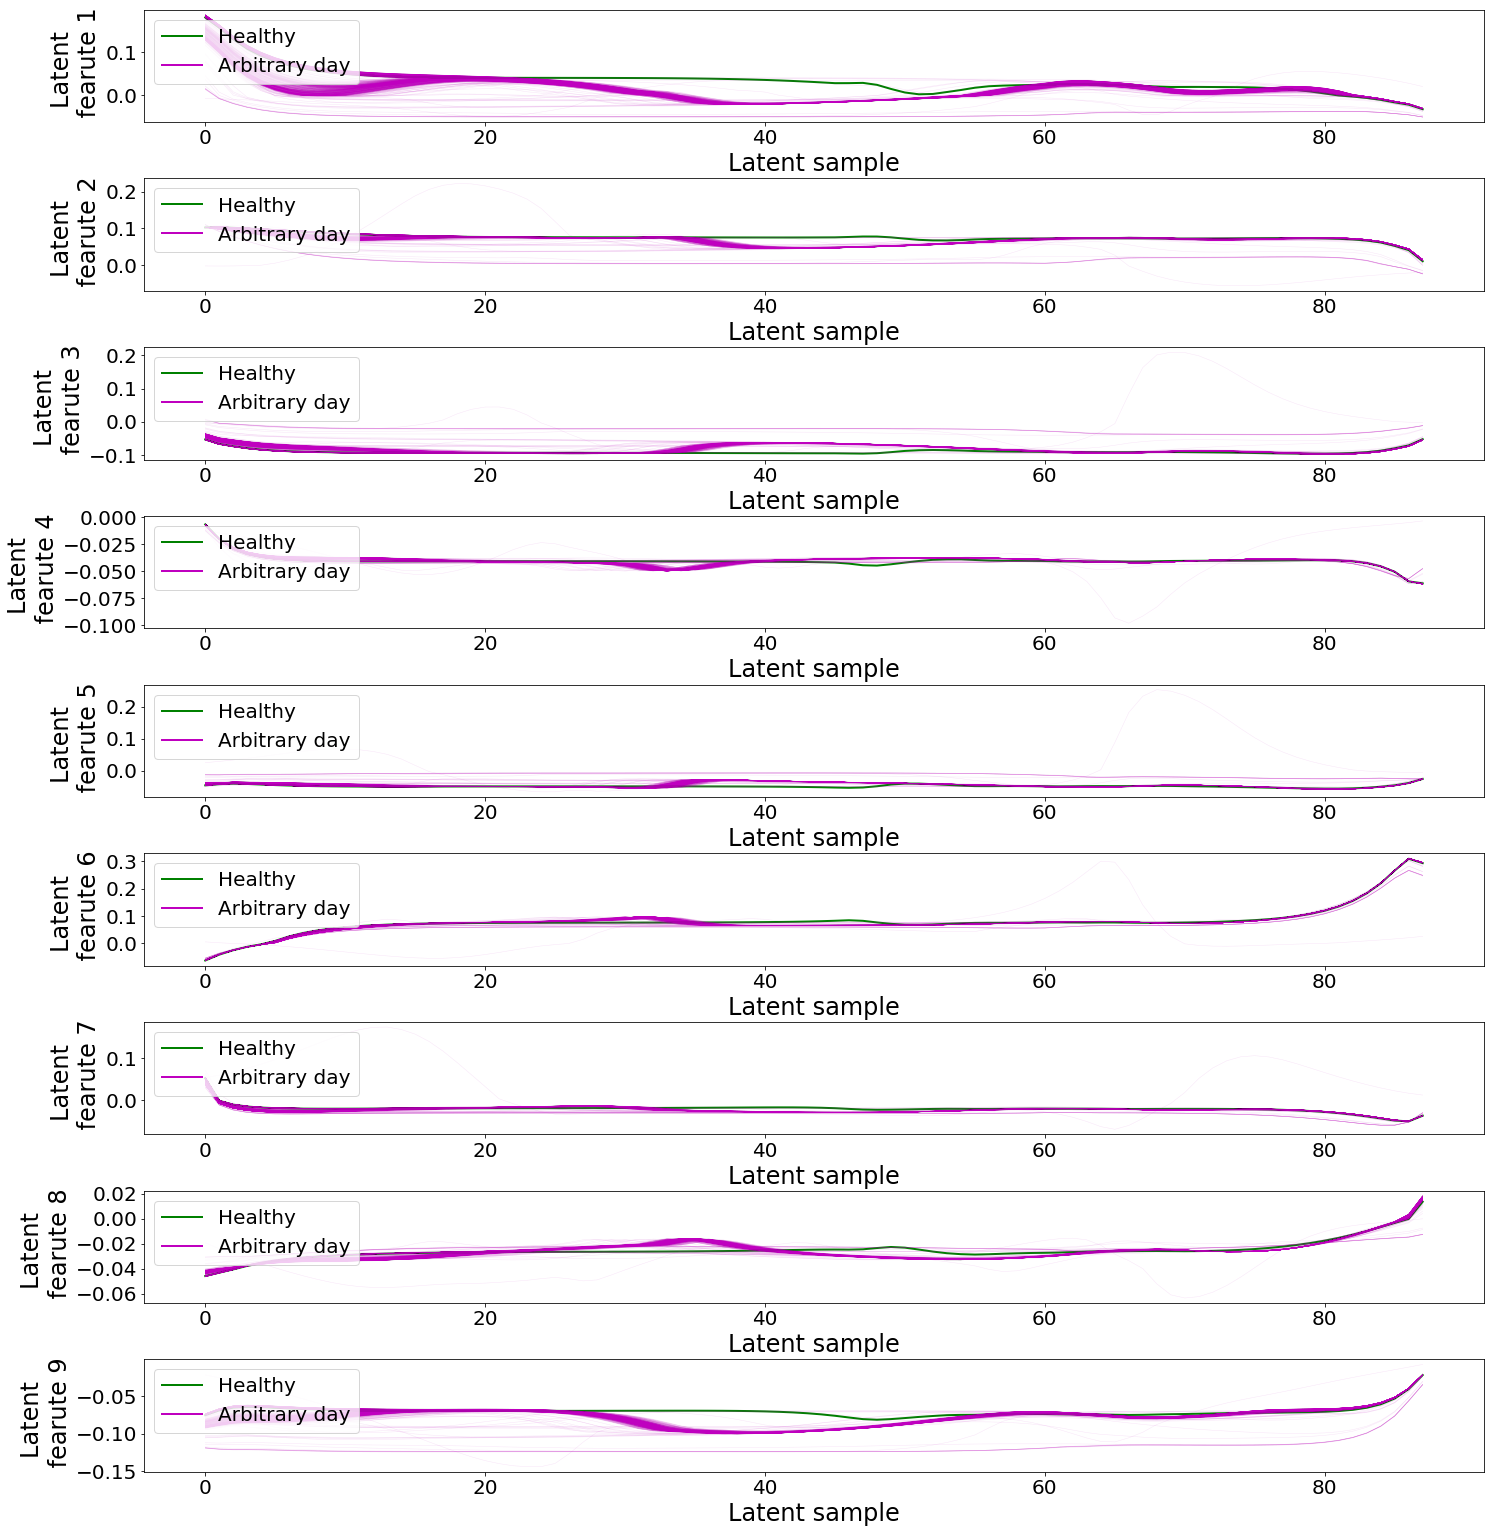

In [34]:
# We load the previously calculated other arbitrary day. This day correspond to the degradation phase.
%store -r X_test0 # Date: 2020-06-10

# Convert to numpy
test_x0=np.array(X_test0).reshape((X_test0.shape[0],X_test0.shape[1],1))

# Predict
intermediate_prediction0=intermediate_model.predict(test_x0)
print("intermediate_prediction0.shape: ",intermediate_prediction0.shape)

# Plot every latent space channel
fig = plt.figure(figsize=(24, 30))

for i in range(1,n_filters):
    # Plot wrong signals
    ax = fig.add_subplot(n_filters, 1, i)
    plt.plot(latent_healthy[:,i-1],color='g',linewidth=2,label='Healthy')
    for j in range(0,len(intermediate_prediction0)):
        plt.plot(intermediate_prediction0[j,:,i-1],color='m',linewidth=0.5,alpha=0.1)
        plt.ylabel('Latent \n fearute '+str(i), fontsize=24)
        plt.xlabel('Latent sample', fontsize=24)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
    
    custom_lines = [Line2D([0], [0], color='g', lw=2),Line2D([0], [0], color='m', lw=2)]
    ax.legend(custom_lines, ['Healthy','Arbitrary day'],loc=2, prop={'size': 20})
    
plt.subplots_adjust(hspace=.5)
plt.savefig("Latent_features3.png", bbox_inches = 'tight')
plt.show()

In [29]:
signals = len(intermediate_prediction0[:,0,0]) # work cycles
channels = len(intermediate_prediction0[0,0,:]) # latent space channels

# Find latent space distances from every work cycle to the healthy state
per_channel_distances = []
for channel in range(0,channels):
    distances = []
    # Iterate over every signal in this channel
    for signal in range(0,signals):
        distance = abs(np.sum(intermediate_prediction0[signal,:,channel] - latent_healthy[:,channel]))
        distances.append(distance)
    # Save channel
    per_channel_distances.append(distances)

# Sum all channels for each work cycle to find its score
score = []
for i in range(0, signals):
    temp = 0
    for j in range(0,channels):
        temp += per_channel_distances[j][i]
        
    # Normalize score against the length of the latent space
    temp = temp/len(intermediate_prediction0[0,:,0])
    
    score.append(temp)

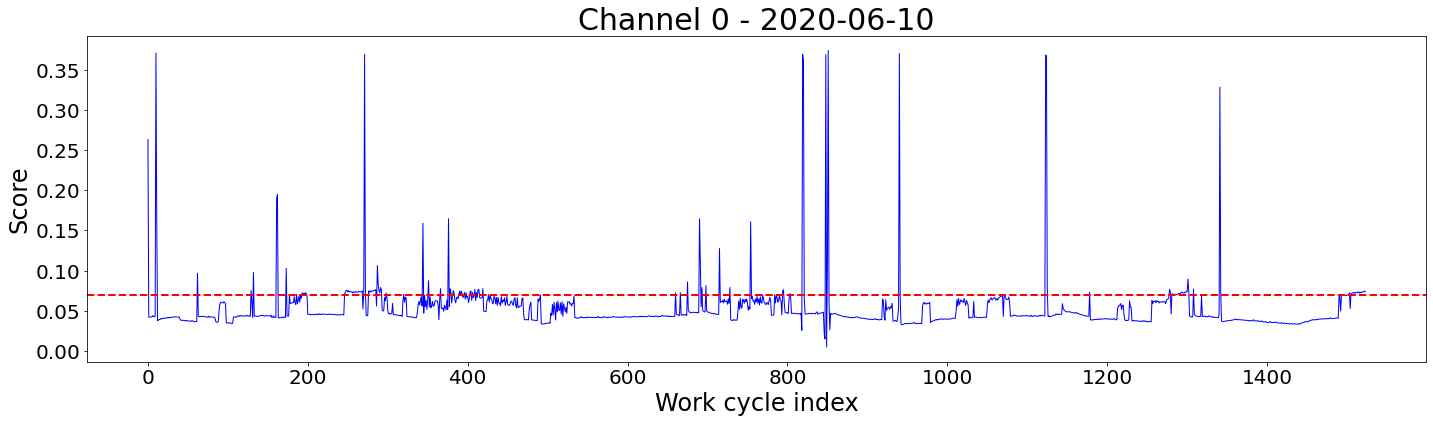

In [30]:
# Print score per signal
fig = plt.figure(figsize=(24, 6))
plt.plot(score,color="blue",linewidth=1) # good signal
plt.title("Channel 0 - 2020-06-10", fontsize=30)
plt.ylabel('Score', fontsize=24)
plt.xlabel('Work cycle index', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.axhline(y=0.07,color='r',linestyle='--',linewidth=2)
plt.savefig("Score 2020-06-10.png", bbox_inches = 'tight')
plt.show()

### 2020-02-04 (Random day)

In [62]:
# Load day in february
pattern = ".*"

# Load the data
data_dir4 = '2020-02-24/device_1_channel_0'
merged_data = pd.DataFrame()
listOfFiles = os.listdir(data_dir4)
for entry in listOfFiles:
    if not fnmatch.fnmatch(entry, pattern):
        df4 = pd.read_parquet(data_dir4 + '/' + entry)
        merged_data = merged_data.append(df4, ignore_index=True, sort=False)
df4 = merged_data
del merged_data

# Replace NaN values
if df4.isnull().sum().sum() > 0:
    df4 = df4.fillna(0)
    print("Nans replaced")
else:
    print("Nothing to replace")

# Find peaks
from scipy.signal import find_peaks
d_coef = 1
peaks4, _ = find_peaks(df4['value'], distance=11000/d_coef, prominence=[20,150], width=[100,11000])
print("Identified peaks in Ch0: ",len(peaks4))

# Divide dataframe into work cycles
c_df4 = pd.DataFrame()
for i in range(0,len(peaks4)):
    temp = df4['value'][peaks4[i]-8000:peaks4[i]+3000]
    temp.reset_index(drop=True, inplace=True)
    c_df4 = pd.concat([c_df4, temp], axis=1, ignore_index=True, sort=False)
del temp

# Normalize the data
X_test4 = c_df4.transpose()/222
print("X_test4 shape: ",X_test4.shape)

%store X_test4

Nothing to replace
Identified peaks in Ch0:  2468
X_test4 shape:  (2468, 11000)
Stored 'X_test4' (DataFrame)


In [26]:
# We load the previously calculated other arbitrary day. This day correspond to the degradation phase.
%store -r X_test4 # Date: 2020-02-24

# Convert to numpy
test_x4=np.array(X_test4).reshape((X_test4.shape[0],X_test4.shape[1],1))

# Predict
intermediate_prediction0=intermediate_model.predict(test_x4)
print("intermediate_prediction0.shape: ",intermediate_prediction0.shape)

signals = len(intermediate_prediction0[:,0,0]) # work cycles
channels = len(intermediate_prediction0[0,0,:]) # latent space channels

# Find latent space distances from every work cycle to the healthy state
per_channel_distances = []
for channel in range(0,channels):
    distances = []
    # Iterate over every signal in this channel
    for signal in range(0,signals):
        distance = abs(np.sum(intermediate_prediction0[signal,:,channel] - latent_healthy[:,channel]))
        distances.append(distance)
    # Save channel
    per_channel_distances.append(distances)

# Sum all channels for each work cycle to find its score
score = []
for i in range(0, signals):
    temp = 0
    for j in range(0,channels):
        temp += per_channel_distances[j][i]
    
    # Normalize score against the length of the latent space
    temp = temp/len(intermediate_prediction0[0,:,0])
    
    # Store
    score.append(temp)

no stored variable or alias #
no stored variable or alias Date:
no stored variable or alias 2020-02-24
intermediate_prediction0.shape:  (2468, 88, 10)


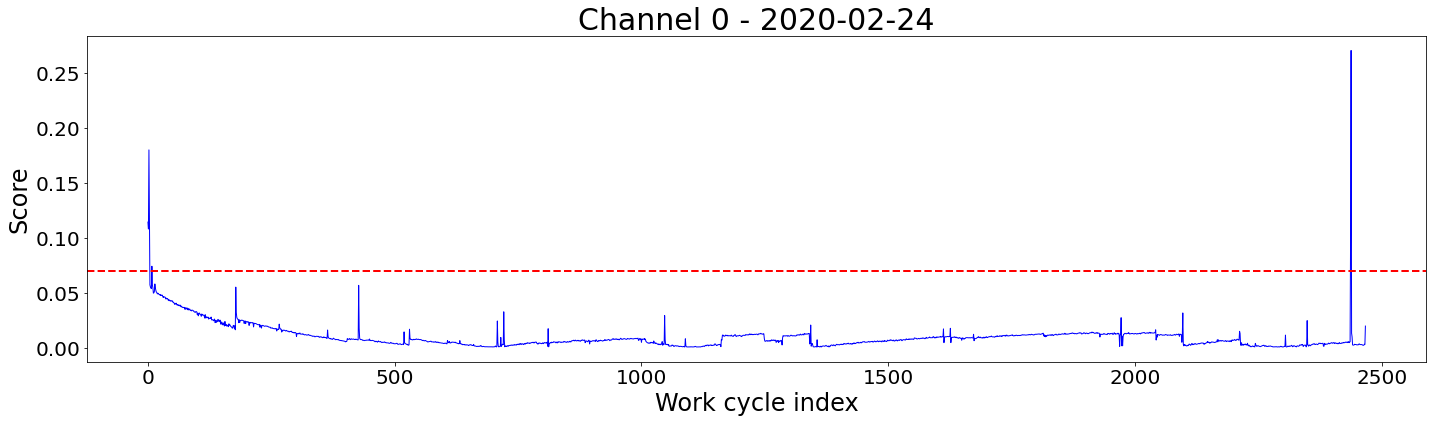

In [27]:
# Print score per signal
fig = plt.figure(figsize=(24, 6))
plt.plot(score,color="blue",linewidth=1) # good signal
plt.title("Channel 0 - 2020-02-24", fontsize=30)
plt.ylabel('Score', fontsize=24)
plt.xlabel('Work cycle index', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.axhline(y=0.07,color='r',linestyle='--',linewidth=2)
plt.savefig("Score 2020-02-24.png", bbox_inches = 'tight')
plt.show()

### 2020-06-03 (Deterioration)

In [24]:
# We load the previously calculated other arbitrary day. This day correspond to the degradation phase.
%store -r X_test2

# Convert to numpy
test_x2=np.array(X_test2).reshape((X_test2.shape[0],X_test2.shape[1],1))

# Predict
intermediate_prediction0=intermediate_model.predict(test_x2)
print("intermediate_prediction0.shape: ",intermediate_prediction0.shape)

signals = len(intermediate_prediction0[:,0,0]) # work cycles
channels = len(intermediate_prediction0[0,0,:]) # latent space channels

# Find latent space distances from every work cycle to the healthy state
per_channel_distances = []
for channel in range(0,channels):
    distances = []
    # Iterate over every signal in this channel
    for signal in range(0,signals):
        distance = abs(np.sum(intermediate_prediction0[signal,:,channel] - latent_healthy[:,channel]))
        distances.append(distance)
    # Save channel
    per_channel_distances.append(distances)

# Sum all channels for each work cycle to find its score
score = []
for i in range(0, signals):
    temp = 0
    for j in range(0,channels):
        temp += per_channel_distances[j][i]
    
    # Normalize score against the length of the latent space
    temp = temp/len(intermediate_prediction0[0,:,0])
    
    # Store
    score.append(temp)

intermediate_prediction0.shape:  (2709, 88, 10)


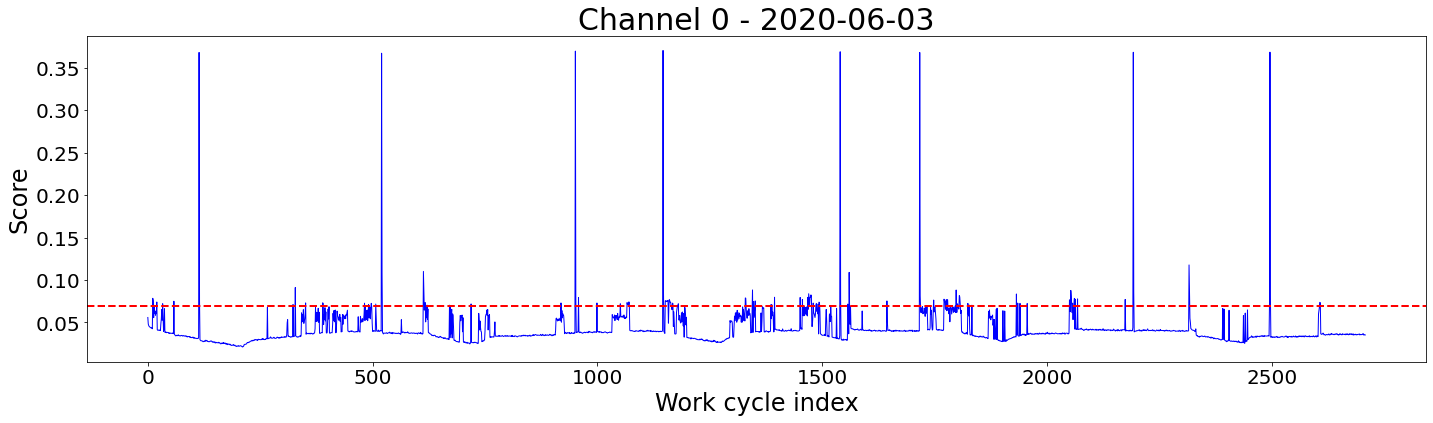

In [25]:
# Print score per signal
fig = plt.figure(figsize=(24, 6))
plt.plot(score,color="blue",linewidth=1) # good signal
plt.title("Channel 0 - 2020-06-03", fontsize=30)
plt.ylabel('Score', fontsize=24)
plt.xlabel('Work cycle index', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.axhline(y=0.07,color='r',linestyle='--',linewidth=2)
plt.savefig("Score 2020-06-03.png", bbox_inches = 'tight')
plt.show()

# The section below are just draft notes

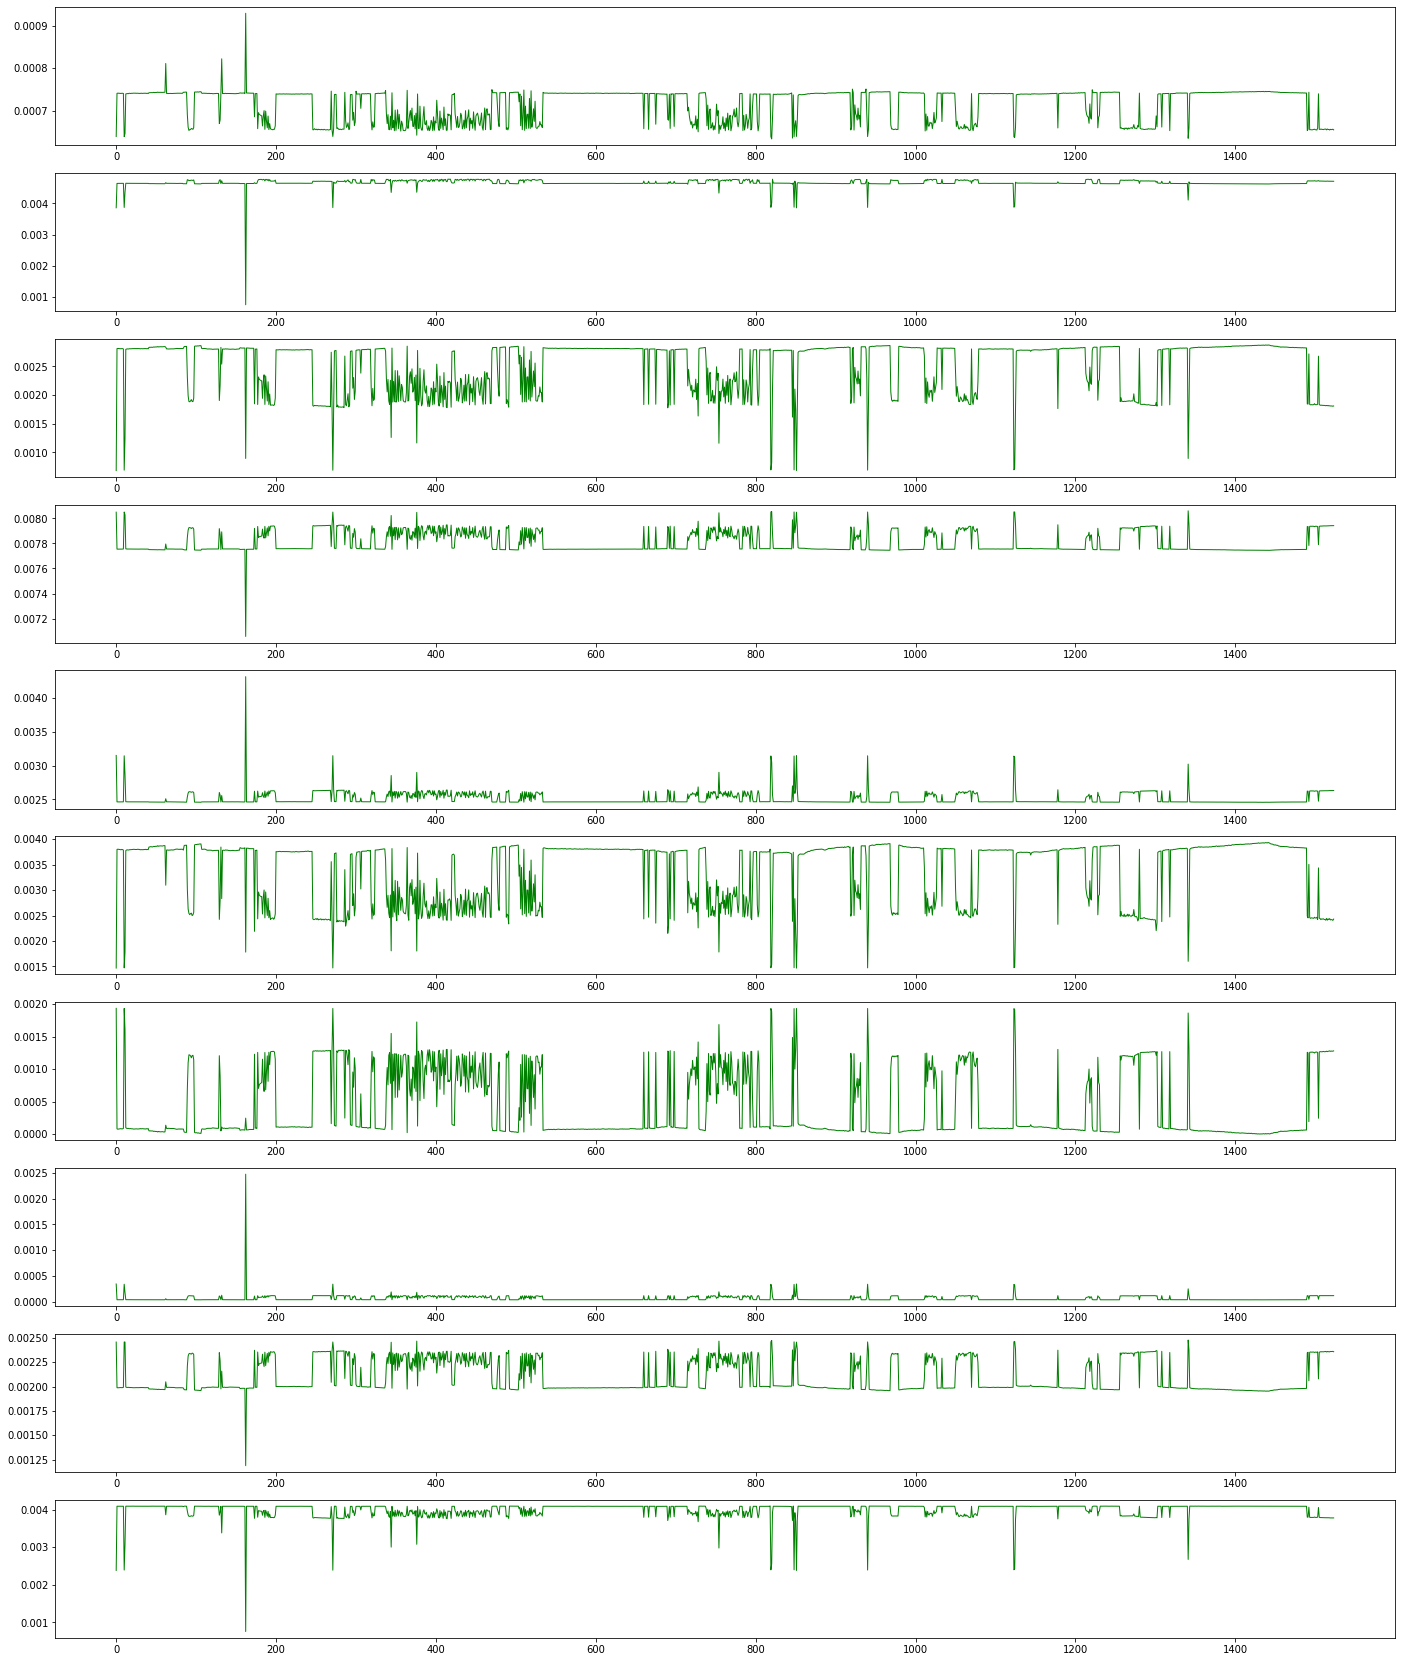

In [170]:
# Print score per channel
fig = plt.figure(figsize=(24, 30))
fig.add_subplot(10, 1, 1)
plt.plot(per_channel_distances[0],color="green",linewidth=1)
fig.add_subplot(10, 1, 2)
plt.plot(per_channel_distances[1],color="green",linewidth=1)
fig.add_subplot(10, 1, 3)
plt.plot(per_channel_distances[2],color="green",linewidth=1)
fig.add_subplot(10, 1, 4)
plt.plot(per_channel_distances[3],color="green",linewidth=1)
fig.add_subplot(10, 1, 5)
plt.plot(per_channel_distances[4],color="green",linewidth=1)
fig.add_subplot(10, 1, 6)
plt.plot(per_channel_distances[5],color="green",linewidth=1)
fig.add_subplot(10, 1, 7)
plt.plot(per_channel_distances[6],color="green",linewidth=1)
fig.add_subplot(10, 1, 8)
plt.plot(per_channel_distances[7],color="green",linewidth=1)
fig.add_subplot(10, 1, 9)
plt.plot(per_channel_distances[8],color="green",linewidth=1)
fig.add_subplot(10, 1, 10)
plt.plot(per_channel_distances[9],color="green",linewidth=1)
plt.show()

error in signal > 80%:  3
80% > error in signal >= 60%:  0
60% > error in signal >= 40%:  6
40% > error in signal >= 20%:  99
20% > error in signal (acceptable):  2407


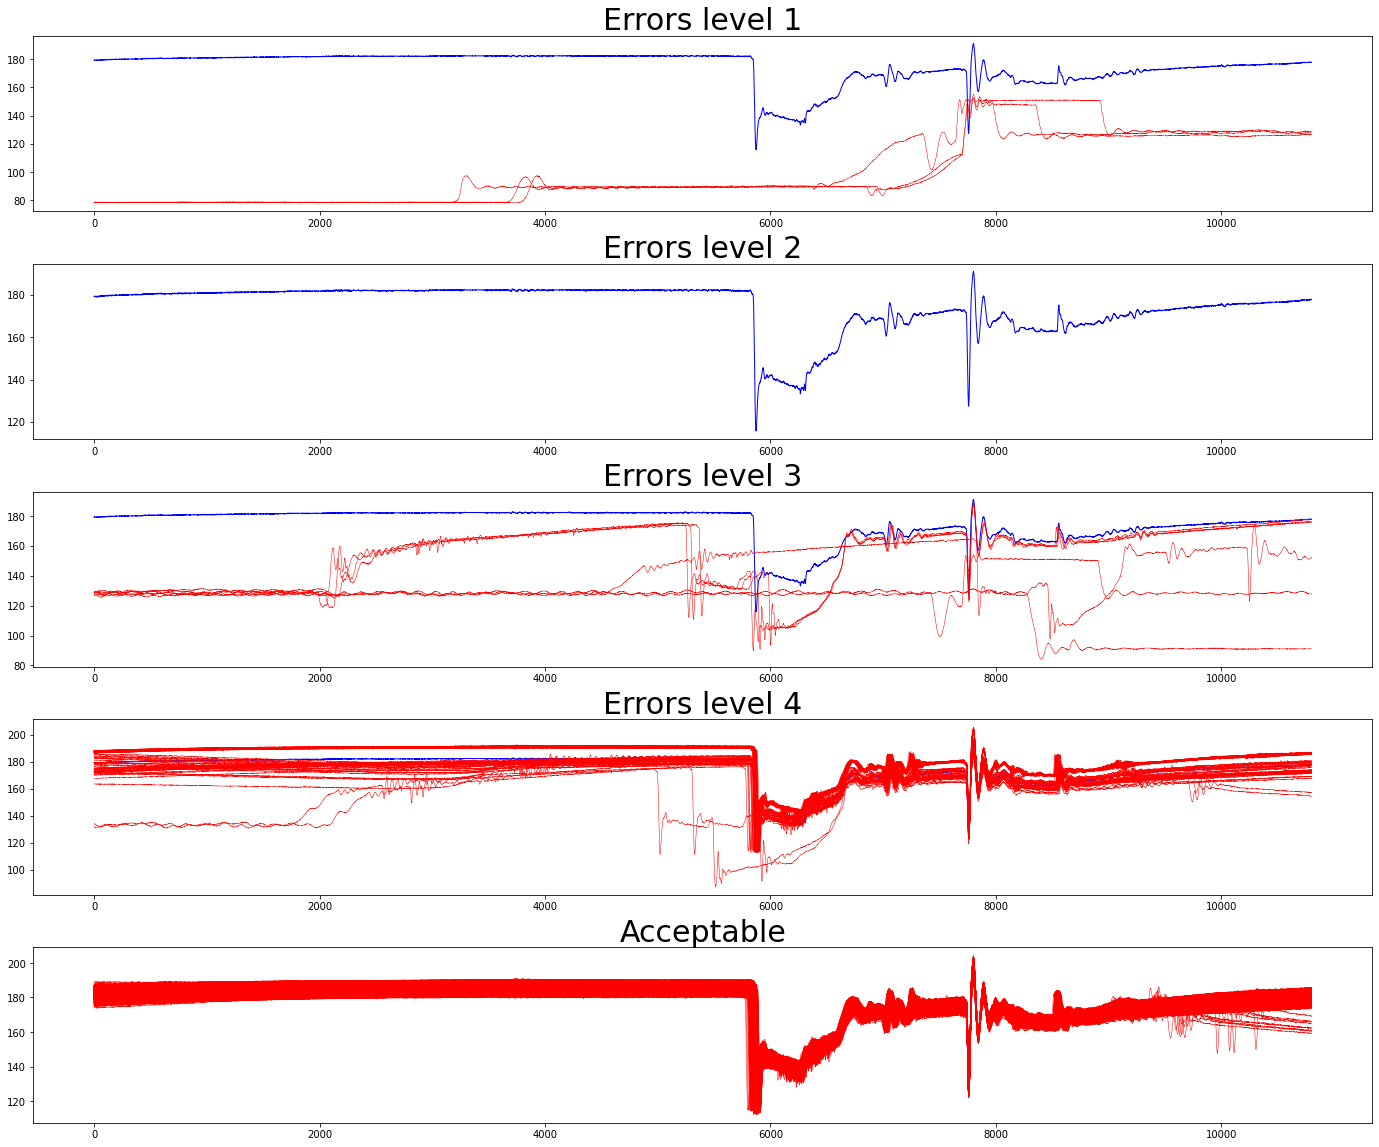

In [27]:
# Identify which signals produce each peak, we skip the first signal because it may have problems
errors_1 = []
for i in range(1, len(score)):
    if score[i] >= .8:
        errors_1.append(i)
#        print("error in signal > 80%  ", i, " with score: ", round(score[i],2))
print("error in signal > 80%: ",len(errors_1))
errors_2 = []
for i in range(1, len(score)):
    if score[i] < .8 and score[i] >= .6:
        errors_2.append(i)
#        print("80% > error in signal >= 60% ", i, " with score: ", round(score[i],2))
print("80% > error in signal >= 60%: ",len(errors_2))
errors_3 = []
for i in range(1, len(score)):
    if score[i] < .6 and score[i] >= .4:
        errors_3.append(i)
#        print("60% > error in signal >= 40% ", i, " with score: ", round(score[i],2))
print("60% > error in signal >= 40%: ",len(errors_3))
errors_4 = []
for i in range(1, len(score)):
    if score[i] < .4 and score[i] >= .05:
        errors_4.append(i)
#        print("40% > error in signal >= 20% ", i, " with score: ", round(score[i],2))
print("40% > error in signal >= 20%: ",len(errors_4))
acceptable = []
for i in range(1, len(score)):
    if score[i] < .05:
        acceptable.append(i)
        #print("20% > error in signal (acceptable)", i, " with score: ", round(score[i],2))
print("20% > error in signal (acceptable): ",len(acceptable))

# After comparing the similarities in the error signals
# 528, 593, 1363 start with a plain part
# 649, ~1226 have a higher peak in the first half
# 1501, 1543 are double signals

# Let's visualize the signals
fig = plt.figure(figsize=(24, 20))
fig.add_subplot(5, 1, 1)
plt.title("Errors level 1", fontsize=30)
# Print good sinals
plt.plot(c_df[[40]],color="blue",linewidth=1)
# Print wrong signals
for i in errors_1:
    plt.plot(c_df[[i]],color="red",linewidth=0.5)

fig.add_subplot(5, 1, 2)
plt.title("Errors level 2", fontsize=30)
# Print good sinals
plt.plot(c_df[[40]],color="blue",linewidth=1)
# Print wrong signals
for i in errors_2:
    plt.plot(c_df[[i]],color="red",linewidth=0.5)

fig.add_subplot(5, 1, 3)
plt.title("Errors level 3", fontsize=30)
# Print good sinals
plt.plot(c_df[[40]],color="blue",linewidth=1)
# Print wrong signals
for i in errors_3:
    plt.plot(c_df[[i]],color="red",linewidth=0.5)

fig.add_subplot(5, 1, 4)
plt.title("Errors level 4", fontsize=30)
# Print good sinals
plt.plot(c_df[[40]],color="blue",linewidth=1)
# Print wrong signals
for i in errors_4:
    plt.plot(c_df[[i]],color="red",linewidth=0.5)

fig.add_subplot(5, 1, 5)
plt.title("Acceptable", fontsize=30)
# Print good sinals
plt.plot(c_df[[40]],color="blue",linewidth=1)
# Print wrong signals
for i in acceptable:
    plt.plot(c_df[[i]],color="red",linewidth=0.5)

plt.subplots_adjust(hspace=0.3)
plt.show()

# Combine plots to identify degradation in the accumulator

In [288]:
# Date: 2020-06-03
temp1_ch0 = X_train.iloc[1,:]
temp1_ch8 = X_train2.iloc[1,:]

In [302]:
# Date: 2020-06-16
temp2_ch0 = X_train.iloc[1,:]
temp2_ch8 = X_train2.iloc[1,:]

In [316]:
# Date: 2020-06-20
temp3_ch0 = X_train.iloc[1,:]
temp3_ch8 = X_train2.iloc[1,:]

In [358]:
# Date: 2020-06-24
temp4_ch0 = X_train.iloc[1,:]
temp4_ch8 = X_train2.iloc[1,:]

In [392]:
# Date: 2020-02-24
temp5_ch0 = X_train.iloc[500,:]
temp5_ch8 = X_train2.iloc[500,:]

### Load and save methods for variables

In [49]:
# Load variables
%store -r temp1_ch0
%store -r temp2_ch0
%store -r temp3_ch0
%store -r temp4_ch0
%store -r temp5_ch0
%store -r temp1_ch8
%store -r temp2_ch8
%store -r temp3_ch8
%store -r temp4_ch8
%store -r temp5_ch8

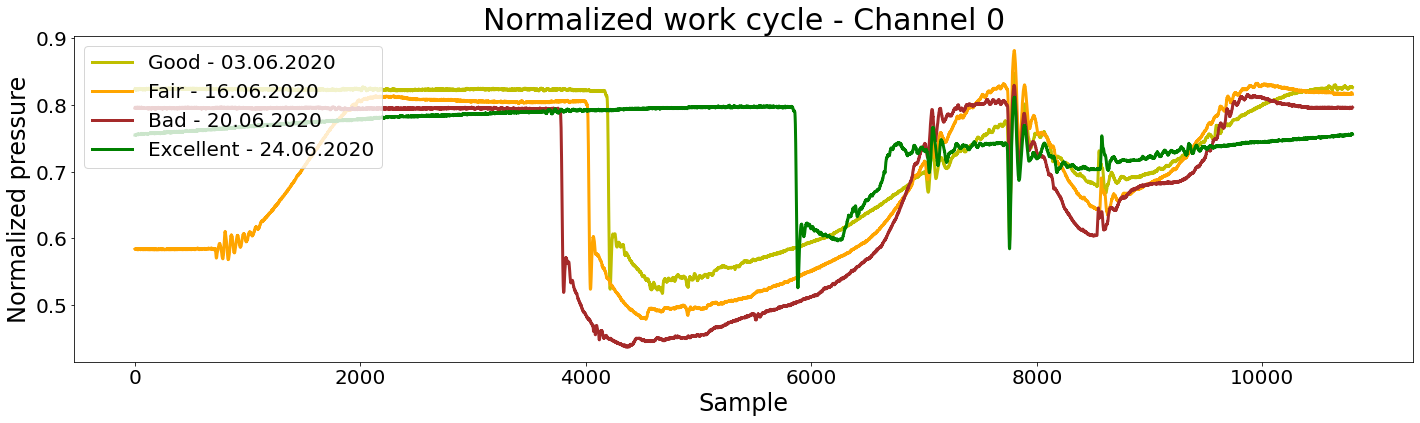

In [56]:
%matplotlib inline
fig = plt.figure(figsize=(24, 6))

ax = fig.add_subplot(1, 1, 1)
plt.title("Normalized work cycle - Channel 0", fontsize=30)
plt.plot(temp1_ch0,color="y",linewidth=3,label='Good - 03.06.2020')
plt.plot(temp2_ch0,color="orange",linewidth=3,label='Fair - 16.06.2020')
plt.plot(temp3_ch0,color="brown",linewidth=3,label='Bad - 20.06.2020')
plt.plot(temp4_ch0,color="g",linewidth=3,label='Excellent - 24.06.2020')
#plt.plot(temp5_ch0,color="m",linewidth=3,label='Random day - 24.02.2020')
plt.xlabel('Sample', fontsize=24)
plt.ylabel('Normalized pressure', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(loc=2, prop={'size': 20})

plt.subplots_adjust(hspace=.5)
plt.savefig("deterioration.png", bbox_inches = 'tight')
plt.show()

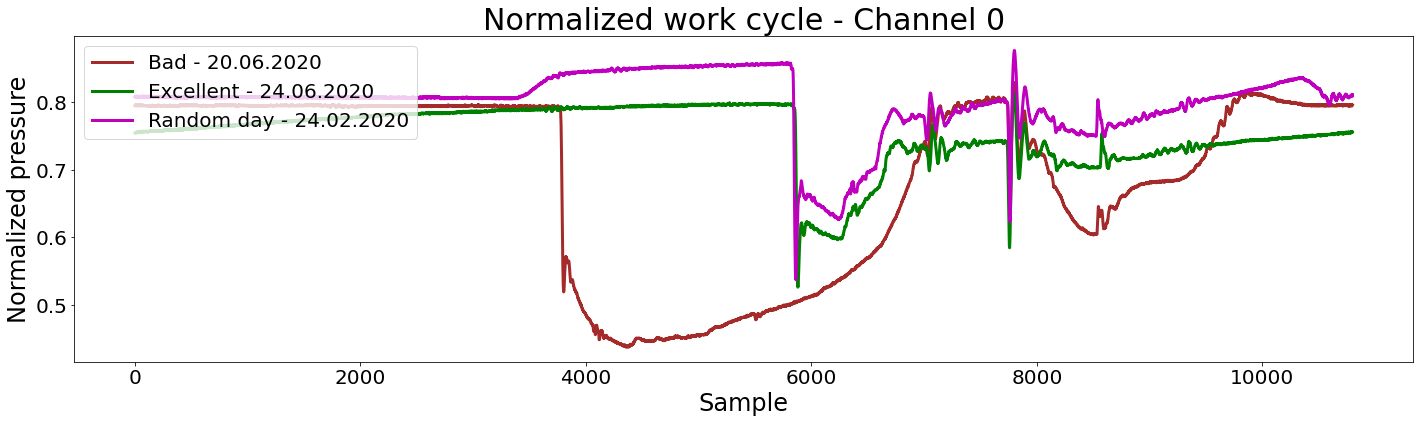

In [67]:
fig = plt.figure(figsize=(24, 6))

ax = fig.add_subplot(1, 1, 1)
plt.title("Normalized work cycle - Channel 0", fontsize=30)
#plt.plot(temp1_ch0,color="y",linewidth=3,label='Good - 03.06.2020')
#plt.plot(temp2_ch0,color="orange",linewidth=3,label='Fair - 16.06.2020')
plt.plot(temp3_ch0,color="brown",linewidth=3,label='Bad - 20.06.2020')
plt.plot(temp4_ch0,color="g",linewidth=3,label='Excellent - 24.06.2020')
plt.plot(temp5_ch0,color="m",linewidth=3,label='Random day - 24.02.2020')
plt.xlabel('Sample', fontsize=24)
plt.ylabel('Normalized pressure', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.legend(loc=2, prop={'size': 20})

plt.subplots_adjust(hspace=.5)
plt.savefig("deterioration_other.png", bbox_inches = 'tight')
plt.show()